In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pytorch ImageFolder 객체에 맞도록 datafolder 구성 (레이블 필요한 경우)

In [ ]:
# filename 에 class 가 바로 대응된 dictionary 파일 읽어옴
import pickle

# dataset에서 file들 가져옴 
import os
import shutil

with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pFileNameToClass.pickle','rb') as fw:
    pFileNameToClass = pickle.load(fw) # O(1) 로 바로 class 찾을 수 있다.

# 인쇄체 데이터 모은 폴더의 이미지들 file list 받음
path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요

# imageFolder 객체에 맞도록 datafolder 구성
pretrain_dir_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset"
os.makedirs(pretrain_dir_path, exist_ok=True)

for filename in file_list:
    label = pFileNameToClass[filename]
    folder_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset/" + str(label)
    os.makedirs(folder_path, exist_ok=True)
    shutil.move(path + '/' + filename, folder_path + '/' + filename)

## Pretrain_DataLoader

#### OSError: errno 5 input/output error 해결하기

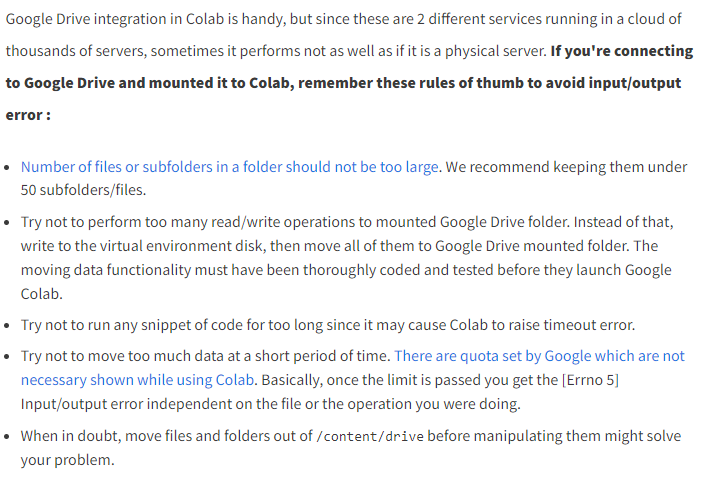

In [ ]:
import os
import shutil

# colab VM disc 사용
dir_path = "/content/data/printed"
os.makedirs(dir_path, exist_ok=True)

# 공유 드라이브의 데이터를 복사해 생성하기
driveFolder = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed'
newFolder = '/content/data/printed'
shutil.copytree(driveFolder, newFolder)

OSError: ignored

In [ ]:
path = "/content/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요
len(file_list)

0

### DataLoader

In [2]:
!unzip '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/cropped_printed.zip' -d .

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./cropped_printed/00216408.png  
  inflating: ./cropped_printed/00021111.png  
  inflating: ./cropped_printed/00030670.png  
  inflating: ./cropped_printed/00227026.png  
  inflating: ./cropped_printed/00059633.png  
  inflating: ./cropped_printed/00192357.png  
  inflating: ./cropped_printed/00078622.png  
  inflating: ./cropped_printed/00167099.png  
  inflating: ./cropped_printed/00215078.png  
  inflating: ./cropped_printed/00087720.png  
  inflating: ./cropped_printed/00190667.png  
  inflating: ./cropped_printed/00225098.png  
  inflating: ./cropped_printed/00083826.png  
  inflating: ./cropped_printed/00028554.png  
  inflating: ./cropped_printed/00109818.png  
  inflating: ./cropped_printed/00224352.png  
  inflating: ./cropped_printed/00122157.png  
  inflating: ./cropped_printed/00047289.png  
  inflating: ./cropped_printed/00071819.png  
  inflating: ./cropped_printed/00172889.png  
  inflating: ./cropped_printed/00005341.png 

In [3]:
from PIL import Image
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [56]:
class SyllablePrintedDataset(Dataset):
    def __init__(self, path, transform):        
        file_list = []
        for filename in os.listdir(path):
            fileName = path + '/' + filename
            file_list.append(fileName)        

        self.transform = transform
        self.dataset = []
        for img_path in file_list[:2500]:
            image = Image.open(img_path)
            img_transformed = self.transform(image)
            self.dataset.append(img_transformed)

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, index):
      return self.dataset[index]

In [42]:
# # dataloader test 
# transform = transforms.Compose([
#                                 transforms.Resize((64,64)),
#                                 transforms.RandomAffine(30),
#                                 transforms.ColorJitter(brightness=(0.2, 1.5), 
#                                                        contrast=(0.2, 3), 
#                                                        saturation=(0.2, 1.5)),
#                                 transforms.ToTensor(),
#                                 ])
# folderpath = '/content/cropped_printed'
# dataset = SyllablePrintedDataset(folderpath, transform)

# print("학습에 사용하는 데이터 수 : ", dataset.__len__())

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [28]:
# # dataloader test
# for imgs in dataloader: # 배치 단위로 iter
#   print(".")

.
.


## WGAN_div Model

In [57]:
import math
import sys
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


output_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/wgan_div'
os.makedirs(output_path, exist_ok=True)

g_lossL = []
d_lossL = []

In [58]:
class Opt:
    def __init__(self, epoch=100, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=2, latent_dim=100, img_size=64, channels=3, n_critic=5, clip_value=0.01, sample_interval=400):
        self.n_epochs = epoch              # number of epochs of training
        self.batch_size = batch_size    # size of the batches
        self.lr = lr                    # adam: learning rate
        self.b1 = b1                    # adam: decay of first order momentum of gradient
        self.b2 = b2                    # adam: decay of first order momentum of gradient
        self.n_cpu = n_cpu              # number of cpu threads to use during batch generation
        self.latent_dim = latent_dim    # dimensionality of the latent space
        self.img_size = img_size        # size of each image dimension
        self.channels = channels        # number of image channels
        self.n_critic = n_critic        # number of training steps for discriminator per iter
        self.clip_value = clip_value    # lower and upper clip value for disc. weights
        self.sample_interval = sample_interval # interval between image sampling
opt = Opt() 

img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

In [59]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            # *block(512, 1024), # 수정
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape) # img_shape : 1, 64, 64
        return img

In [60]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [61]:
k = 2
p = 6

if not cuda:
    print("GPU 써라")

# Initialize generator and discriminator
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# 수정
transform = transforms.Compose([
                                transforms.Resize((64,64)),
                                transforms.RandomAffine(30),
                                transforms.ColorJitter(brightness=(0.2, 1.5), 
                                                       contrast=(0.2, 1.5), 
                                                       saturation=(0.2, 1.5)),
                                transforms.ToTensor(),
                                ])
folderpath = '/content/cropped_printed'
dataset = SyllablePrintedDataset(folderpath, transform)
print("학습에 사용하는 데이터 수 : ", dataset.__len__())

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

학습에 사용하는 데이터 수 :  2500


In [62]:
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)
        print(np.shape(real_imgs))
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input       
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_lossL.append(d_loss)

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_lossL.append(g_loss)
            
            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1, opt.n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/outputs/wgan_div/images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic

torch.Size([64, 3, 64, 64])
[Epoch 1/100] [Batch 1/40] [D loss: -0.017685] [G loss: 0.074883]
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
[Epoch 1/100] [Batch 6/40] [D loss: -21.887218] [G loss: 0.069696]
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
[Epoch 1/100] [Batch 11/40] [D loss: -56.535664] [G loss: -0.319279]
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
[Epoch 1/100] [Batch 16/40] [D loss: -53.335945] [G loss: -0.670287]
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
[Epoch 1/100] [Batch 21/40] [D loss: -52.166168] [G loss: -1.286571]
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 

RuntimeError: ignored

In [ ]:
# 학습된 모델 저장 
generator_out_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/wgan_div/generator.pth'
torch.save(generator.state_dict(), generator_out_path)

discriminator_out_path = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/model/wgan_div/discriminator.pth'
torch.save(discriminator.state_dict(), discriminator_out_path)

In [ ]:
import csv # csv파일로 적기 # newline 설정을 안하면 한줄마다 공백있는 줄이 생긴다. 
with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/lossFile.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(g_lossL) 
    writer.writerow(d_lossL) 

### github 커밋

In [23]:
MY_GOOGLE_DRIVE_PATH = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital


In [24]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper
!git pull

Already up to date.


In [25]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   .gitignore
	modified:   GAN/Parsing.ipynb
	modified:   GAN/WGAN_DIV.ipynb
	modified:   "object_detection/github_util.ipynb\341\204\213\341\205\264 \341\204\211\341\205\241\341\204\207\341\205\251\341\206\253\341\204\213\341\205\264 \341\204\211\341\205\241\341\204\207\341\205\251\341\206\253"

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	GAN/outputs/
	object_detection/__pycache__/
	object_detection/config.py
	object_detection/ctpn_model.py
	object_detection/ctpn_utils.py
	object_detection/dataset.py
	object_detection/error_imgs.txt
	object_detection/test_data_generating_file/data_crawer.ipynb
	object_detection/test_data_generating_file/index.html?com=downloads
	object_detection/text_detector.ipynb

no change

In [26]:
!git add GAN/WGAN_DIV.ipynb

In [27]:
!git commit -m"[FIX] Dataloader using zipFile"

[main 64f6db7] [FIX] Dataloader using zipFile
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite GAN/WGAN_DIV.ipynb (92%)


In [28]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 114.67 KiB | 6.74 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital.git
   c941a21..64f6db7  main -> main
